In [35]:
import re
import os
import sys
import h5py
import time
import numpy as np
import scipy as sp
from utils import *
import mindspore as ms
from numpy.linalg import eig, norm
from scipy.sparse import csr_matrix
from scipy.optimize import minimize
from mindquantum.framework import *
from mindquantum.core.gates import *
from scipy.stats import unitary_group
from mindquantum.core.circuit import *
from IPython.display import display_svg
from mindquantum.core.operators import *
from mindquantum.algorithm.nisq import *
from scipy.linalg import block_diag, sqrtm
from mindspore.common.initializer import *
from mindquantum.simulator import Simulator
from mindquantum.algorithm.compiler import *

np.set_printoptions(linewidth=200)

In [22]:
g = h5py.File('mat/322_d2_num1_model957_site3_G_gates_L39.mat', 'r')
position = g['position'][:] - 1  # subtract index of matlab to python
l = list(g.keys())  # list of HDF5 file keys
g_name = [x for x in l if 'gates' in x]  # list of Q_gates_?
key = lambda x: [int(s) if s.isdigit() else s for s in re.split('(\d+)', x)]
g_name = sorted(g_name, key=key)  # sort 1,10,11,...,2 into 1,2,...,10,11
# print(position, g_name)
k = g[g_name[0]].shape[0]  # number of gates in one layer
gates = [[g[g[i][j]][:].view('complex').T for j in range(k)] for i in g_name]
g.close()

r = h5py.File('mat/322_d2_num1_model957_RDM_v7.3.mat', 'r')
l = list(r.keys())
rdm = [r[i][:].view('complex').T for i in l]
rdm.insert(0, [])
r.close()

d = 3
# print(rdm[d], rdm[d].shape)
print('rdm[%d] trace:%.20f' % (d, np.real(np.trace(rdm[d]))))
print('rdm[%d]^2 trace:%.20f' % (d, np.real(np.trace(rdm[d] @ rdm[d]))))

rdm[3] trace:1.00000000000000532907
rdm[3]^2 trace:0.76610910429334222460


========Circuit Summary========
|Total number of gates  : 351.|
|Parameter gates        : 0.  |
|with 0 parameters are  :     |
|                        .    |
|Number qubit of circuit: 9   |
==================================================================Circuit Summary==================================================================
|Total number of gates  : 468.                                                                                                                    |
|Parameter gates        : 156.                                                                                                                    |
|with 156 parameters are:                                                                                                                         |
|G9_L1_lam, G9_L1_theta, G9_L1_phi, G9_L1_phase, G9_L2_lam, G9_L2_theta, G9_L2_phi, G9_L2_phase, G9_L3_lam, G9_L3_theta..                        .|
|Number qubit of circuit: 9                                         

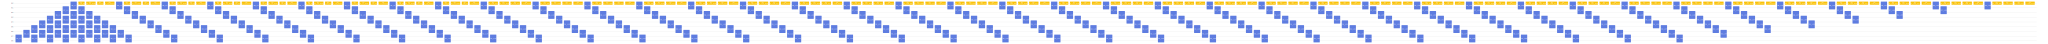

In [7]:
pr = {}
circ_u = Circuit()
circ_d = Circuit()
for i in range(len(g_name)):
    for j in range(k):
        gate_name = 'G' + str(j + 1) + '_L' + str(i + 1)
        gate_mat = gates[i][j]
        if j == k - 1:
            gate_u = UnivMathGate(gate_name, gate_mat).on(k - 1)
            gate_d, para = one_qubit_decompose(gate_u)
            pr.update(para)
            circ_u += gate_u
            circ_d += gate_d
            # circ_d += euler_decompose(gate_u)
        else:
            gate_u = UnivMathGate(gate_name, gate_mat).on([j, j + 1])
            gate_d = gate_u
            circ_u += gate_u
            circ_d += gate_d
            # circ_d += qs_decompose(gate_u)

circ_u.summary()
circ_d.summary()

sim_u = Simulator('mqvector', k)
sim_d = Simulator('mqvector', k)
sim_u.apply_circuit(circ_u)
sim_d.apply_circuit(circ_d.apply_value(pr))
psi_u = sim_u.get_qs()
psi_d = sim_d.get_qs()
rho_u = np.outer(psi_u.conj(), psi_u)
rho_d = np.outer(psi_d.conj(), psi_d)

print('circ norm: %.20f' % norm(circ_u.matrix() - circ_d.matrix(pr)))
print('psi norm: %.20f, fidelity: %.20f' % (norm(psi_u - psi_d, 2), fidelity(psi_u, psi_d)))
print('rho norm: %.20f, fidelity: %.20f' % (norm(rho_u - rho_d, 2), fidelity(rho_u, rho_d)))

rho = reduced_density_matrix(rho_u, position)
# print(rho, rho.shape)
print('rho trace: %.20f' % np.real(np.trace(rho)))
print('rho^2 trace: %.20f' % np.real(np.trace(rho @ rho)))
print(fidelity(rdm[3], rho), norm(rdm[3] - rho, 2))

circ_d.reverse_qubits().svg()

In [39]:
circ = Circuit()
mat = np.eye(2**k)
for i in range(len(g_name)):
    for j in range(k):
        gate_name = 'G' + str(j + 1) + '_L' + str(i + 1)
        gate_mat = gates[i][j]
        if j == k - 1:
            circ += UnivMathGate(gate_name, gate_mat).on(k - 1)
            temp = np.kron(gate_mat, np.eye(2**j))
        else:
            circ += UnivMathGate(gate_name, gate_mat).on([j, j + 1])
            temp = np.kron(np.eye(2**(k - j - 2)), np.kron(gate_mat, np.eye(2**j)))
        mat = temp @ mat
circ = circ.hermitian()
mat = mat.conj().T

sim = Simulator('mqvector', k)
psi0 = sim.get_qs()
sim.apply_circuit(circ)
psi = sim.get_qs()
rho = np.outer(psi.conj(), psi)

print(np.allclose(psi, mat @ psi0), np.allclose(mat, circ.matrix()))

rho = reduced_density_matrix(rho, position)
# # print(rho, rho.shape)
print('rho trace: %.20f' % np.real(np.trace(rho)))
print('rho^2 trace: %.20f' % np.real(np.trace(rho @ rho)))
print(fidelity(rdm[3], rho), norm(rdm[3] - rho, 2))

# circ.reverse_qubits().svg()

True True
rho trace: 0.99999999999998956390
rho^2 trace: 0.57810845705143332207
0.811183594667064 0.4963597816115463


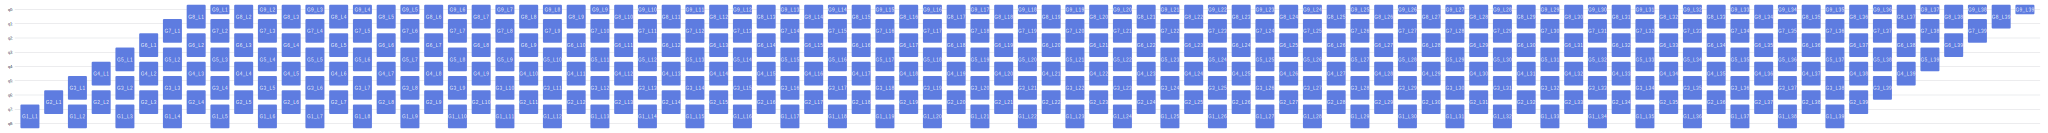

In [9]:
circ_u = Circuit()
for i in range(len(g_name)):
    for j in range(k):
        gate_name = 'G' + str(j + 1) + '_L' + str(i + 1)
        gate_mat = gates[i][j]
        if j == k - 1:
            circ_u += UnivMathGate(gate_name, gate_mat).on(k - j - 1)
        else:
            circ_u += UnivMathGate(gate_name, gate_mat).on([k - j - 2, k - j - 1])

circ_u.svg()

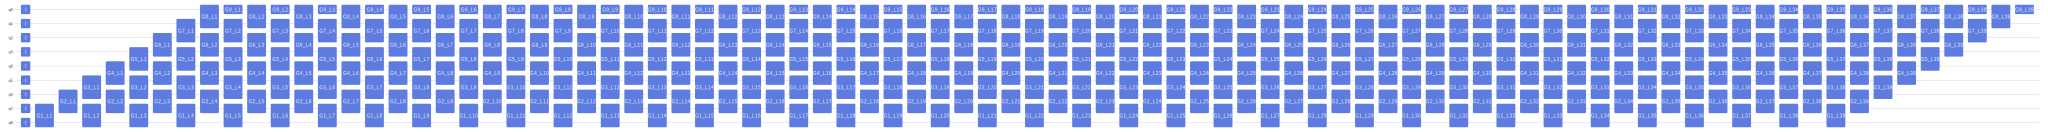

In [10]:
circ_u = Circuit() + UN(I, k)
for i in range(len(g_name)):
    for j in range(k):
        gate_name = 'G' + str(j + 1) + '_L' + str(i + 1)
        gate_mat = gates[i][j]
        if j == k - 1:
            circ_u += UnivMathGate(gate_name, gate_mat).on(k - j - 1)
        else:
            circ_u += UnivMathGate(gate_name, gate_mat).on([k - j - 1, k - j - 2])

display_svg(circ_u.svg())
circ_u = circ_u.reverse_qubits()

In [11]:
# d = 9
# p = [3, 4, 5]
# b = np.zeros([d, 2, 2], dtype=complex)
# for i in range(d):
#     a = np.random.rand(2) + 1j * np.random.rand(2)
#     a /= norm(a)
#     b[i] = np.outer(a, a.conj())
# c = b[0]
# for i in range(1, d):
#     c = np.kron(c, b[i])
# d = b[p[0]]
# for i in p[1::]:
#     d = np.kron(d, b[i])
# rho = reduced_density_matrix(c, p)
# print(rho, rho.shape)
# print(np.trace(rho))
# print(np.trace(rho @ rho))
# rho -= d
# rho[abs(rho) < 1e-15] = 0
# print(rho)

rho = reduced_density_matrix(rho_u, position)
print(rho, rho.shape)
print(np.trace(rho))
print(np.trace(rho @ rho))

print(fidelity(rdm[3], rho))

[[ 7.40991296e-01+0.00000000e+00j -5.57807601e-03-1.95741392e-01j  2.48931840e-01-4.74828152e-02j  8.00114306e-02+9.16449363e-03j  2.17335598e-01-2.12213407e-02j  5.47067872e-03-4.45790394e-02j
   5.05723072e-02+5.26591753e-03j -5.86807867e-03-2.52751904e-02j]
 [-5.57807601e-03+1.95741392e-01j  5.34675825e-02+0.00000000e+00j  1.06383339e-02+6.63912051e-02j -3.41599551e-03+2.11698215e-02j  4.84055781e-03+5.70231776e-02j  1.16697771e-02+1.54285806e-03j
  -1.38527997e-03+1.30832191e-02j  6.43432865e-03-8.96837578e-04j]
 [ 2.48931840e-01+4.74828152e-02j  1.06383339e-02-6.63912051e-02j  8.73911788e-02+0.00000000e+00j  2.62617287e-02+8.64000369e-03j  7.47783231e-02+5.36454878e-03j  4.29589146e-03-1.46368393e-02j
   1.64583402e-02+4.57416126e-03j -2.23627381e-04-8.99707965e-03j]
 [ 8.00114306e-02-9.16449363e-03j -3.41599551e-03-2.11698215e-02j  2.62617287e-02-8.64000369e-03j  1.00533708e-02+0.00000000e+00j  2.29391571e-02-4.70394560e-03j  3.21561586e-04-4.65939655e-03j
   5.47037915e-03+2.238

In [12]:
# np.random.seed(42)
a = np.random.rand(2) + 1j * np.random.rand(2)
print(np.outer(a.conj(), a))
print(np.outer(a, a.conj()))
a = np.array([a])
print(a.conj().T @ a)
print(a.T @ a.conj())

[[0.25307973+0.j         0.2038169 -0.15669995j]
 [0.2038169 +0.15669995j 0.26116751+0.j        ]]
[[0.25307973+0.j         0.2038169 +0.15669995j]
 [0.2038169 -0.15669995j 0.26116751+0.j        ]]
[[0.25307973+0.j         0.2038169 -0.15669995j]
 [0.2038169 +0.15669995j 0.26116751+0.j        ]]
[[0.25307973+0.j         0.2038169 +0.15669995j]
 [0.2038169 -0.15669995j 0.26116751+0.j        ]]


7 ['F_1', 'F_2', 'F_3', 'F_4', 'F_5'] ['gates_1', 'gates_2', 'gates_3', 'gates_4', 'gates_5']
[[ 0.92523302+0.j         -0.05990392+0.03756126j]
 [-0.05990392-0.03756126j  0.07476698+0.j        ]] (2, 2)
(0.9999999999999989+0j)
(0.8716448909527182+0j)


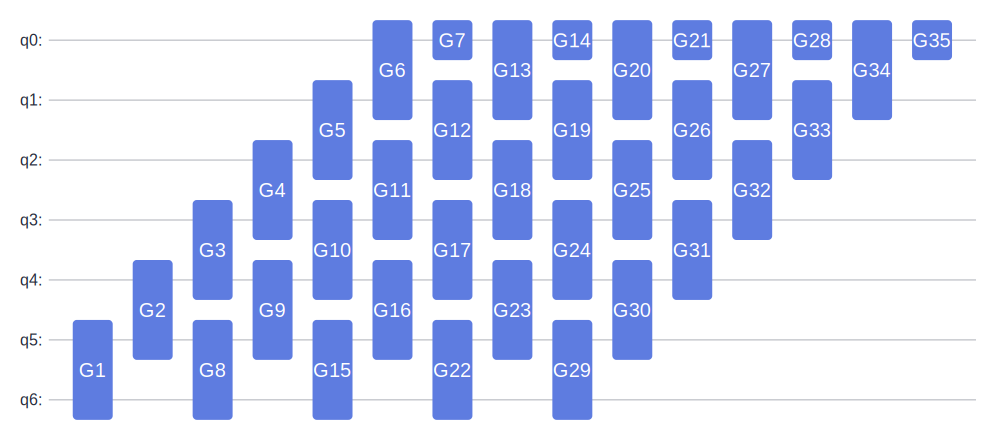

In [13]:
# don't use this file
g = h5py.File('mat/322_d2_num1_model957_body1_G_gates.mat')
l = list(g.keys())
f_name = [x for x in l if 'F_' in x]
g_name = [x for x in l if 'gates' in x]
k = g[g_name[0]].shape[0]
print(k, f_name, g_name)
fidelity = [g[i][:] for i in f_name]
gates = [[g[g[i][j]][:].view('complex').T for j in range(k)] for i in g_name]

circ_univ = Circuit()
for i in range(len(g_name)):
    for j in range(k):
        gate_name = 'G' + str(i * k + j + 1)
        gate_mat = gates[i][j]
        if j == k - 1:
            circ_univ += UnivMathGate(gate_name, gate_mat).on(k - j - 1)
        else:
            circ_univ += UnivMathGate(gate_name,
                                      gate_mat).on([k - j - 2, k - j - 1])
sim = Simulator('mqvector', k)
sim.apply_circuit(circ_univ)

psi = sim.get_qs()
rho = np.outer(psi, psi.conj())
rho = reduced_density_matrix(rho, [4])
print(rho, rho.shape)
print(np.trace(rho))
print(np.trace(rho @ rho))
circ_univ.svg()